# IMPORT LIBRARIES

In [1]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, roc_auc_score,
                            classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import scikitplot as skplt
import soundfile as sf
from soundfile import SoundFile
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq, rfftfreq, rfft
import math
import antropy as ant
import seaborn as sns
from scipy.stats import norm, kurtosis
from pedalboard import LadderFilter, Pedalboard
#plt.style.use('dark_background')

# LOAD INSTRUMENTS

### NUMERO DE SAMPLES POR INSTRUMENTO

In [2]:
numSounds = 50

### SOUND PATHS

In [3]:
kicksPath = "../InstrumentsClassifier/Instruments/Kicks/"
snarePath = "../InstrumentsClassifier/Instruments/Snares/"
hihatPath = "../InstrumentsClassifier/Instruments/HiHats/"
guitarPath = "../InstrumentsClassifier/Instruments/Guitars/"

kicks = []
snares = []
hihats = []
guitars = []

### LOAD KICKS

In [4]:
# OBTAIN KICKS AUDIO SAMPLES
for i in range(numSounds):
    path = kicksPath + "Kick_" + str(i+1) + ".wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        kicks.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        kicks.append([sound[:,0], sr])

### LOAD SNARES

In [5]:
# OBTAIN SNARE AUDIO SAMPLES
for i in range(numSounds):
    path = snarePath + "Snare_" + str(i+1) + ".wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        snares.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        snares.append([sound[:,0], sr])

### LOAD HI HATS

In [6]:
# OBTAIN HIHAT AUDIO SAMPLES
for i in range(numSounds):
    path = hihatPath + "Hihat_" + str(i+1) + ".wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        hihats.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        hihats.append([sound[:,0], sr])

### LOAD GUITARS

In [7]:
# OBTAIN HIHAT AUDIO SAMPLES
for i in range(numSounds):
    path = guitarPath + "Guitar_" + str(i+1) + ".wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        guitars.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        guitars.append([sound[:,0], sr])

# SEE AND ANALIZE SOUNDS

### FUNCTIONS TO SEE WAVEFORM, SPECTROGRAM AND FFT

In [8]:
def graph_spectrogram(samples, sr, title):    
    plt.figure(figsize=(10,6))
    plt.specgram(samples)
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
def graph_waveform(samples, sr, title):  
    plt.figure(figsize=(10,6))
    plt.plot(samples)
    plt.title(title)
    plt.ylabel('Linear Amplitude')
    plt.xlabel('Time')
    plt.show()

def graph_spectrum(samples, sr, title):
    N = len(samples)
    T = 1/sr
    yf = fft(samples)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

### PLOT AUDIO IN TIME DOMAIN

### Explicar el comportamiento de las graficas y la naturaleza de los sonidos

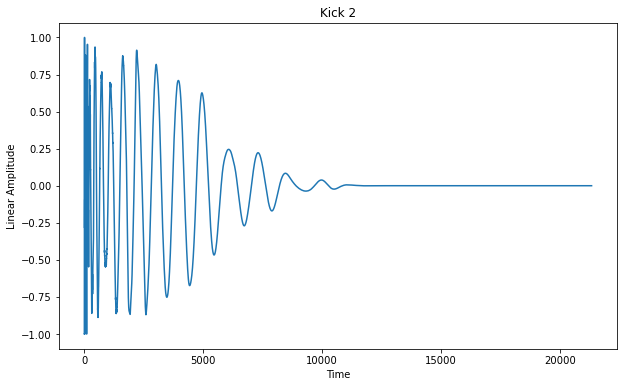

In [9]:
numKick = 2
graph_waveform(kicks[numKick-1][0], kicks[numKick-1][1], "Kick " + str(numKick))

### PLOT AUDIO IN FREQUENCY DOMAIN

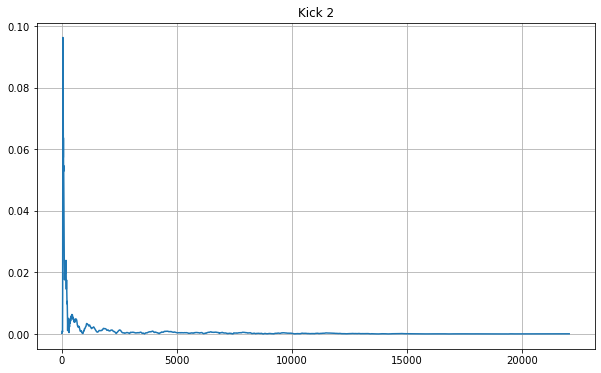

In [10]:
numKick = 2
graph_spectrum(kicks[numKick-1][0], kicks[numKick-1][1], "Kick " + str(numKick))

# PRE PROCESSING

### CALCULATE CENTROID FOR ALL THE SOUNDS

In [11]:
kicks_centroid = []
snares_centroid = []
hihats_centroid = []
guitars_centroid = []

cont = 0
for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    kicks_centroid.append(centroid)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    snares_centroid.append(centroid)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    hihats_centroid.append(centroid)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    guitars_centroid.append(centroid)

print("Instrument:", guitars_centroid)

Instrument: [2067.2182953615797, 971.7122630706654, 2175.9900361749524, 2298.647100280113, 4172.693280872488, 4280.405238274479, 4139.058366523015, 1471.0684617760419, 2504.6730508000846, 1745.7493813593755, 1142.0621485060308, 1067.2626537095998, 1313.2291952893781, 1083.9363996257484, 2651.2081965949887, 826.6719202260253, 1659.8689625729683, 1445.3576830209256, 1717.228177450321, 1526.2105855256464, 1628.5534177248571, 1869.644925474004, 1710.0181728427237, 2035.011242857067, 1619.2141208849941, 2233.700918097664, 2409.8898015462896, 2287.312299414072, 2040.3341879857596, 1883.0356562893526, 1879.2043460383343, 1704.7554495569793, 2319.024120322133, 1475.489274886016, 1556.2998131085824, 1668.7189842856778, 1034.546878915588, 2181.701894820413, 559.2776997002152, 1652.7963169360899, 2053.802702014524, 1546.1243814856139, 5301.225124151047, 1663.4931531905793, 1790.7071569452721, 632.553824496908, 672.7269441297498, 683.6834211150851, 530.3916597972357, 1439.6182851546978]


### CALCULATE SPREAD

In [12]:
kicks_spread = []
snares_spread = []
hihats_spread = []
guitars_spread = []

def spectralSpread(inFrequency, inAmplitude, inCentroid):
    i = 0
    numerator = 0
    denominator = 0
    for frequency in inFrequency:
        numerator += (frequency - inCentroid) ** 2 * inAmplitude[i]
        denominator += inAmplitude[i]
        i += 1
    return math.sqrt(numerator / denominator)

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    kicks_spread.append(spread)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    snares_spread.append(spread)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    hihats_spread.append(spread)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    guitars_spread.append(spread)

print("Instrument:", guitars_spread)

Instrument: [1780.728777136958, 1506.8647626918998, 1771.3548386115965, 1858.6891608211338, 4518.997004538873, 4499.324105932673, 4380.027694194762, 1976.1887316723032, 2646.623155768237, 1578.3467409398438, 1186.039293105764, 1410.93184110435, 1983.2170087493732, 1229.8983139207357, 2040.5078135151493, 1905.4457923332989, 1306.0651195013356, 1696.5918501834972, 1636.3222049248216, 1109.4845256689268, 1135.8001637452373, 1142.3624882341958, 1057.7167675433875, 1416.0833681977822, 1279.4988134139599, 1463.0713411437912, 1231.0959325237197, 1640.09436645708, 1719.8034341307539, 1653.432921170242, 1676.989770421631, 1568.595878521969, 1808.503815235594, 1966.7110320437102, 1536.640189879959, 1856.6533814901165, 1126.1705937691447, 3248.4953013671593, 1905.3130002465, 1981.4540215850484, 1876.8027887050812, 1192.2635517990432, 4959.462420770991, 1519.7945250918297, 2137.874434728721, 930.7658499595899, 820.5416334908748, 850.4944682266226, 774.1671634270086, 1268.5127712417154]


### CALCULATE AND APPLY FILTERS

In [13]:
def highPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def LowPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.LPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def makeFilters(inSamples, inLow, inHigh):
    inSamples[0] = highPassProcess(inSamples[0], inHigh, inSamples[1])
    inSamples[0] = LowPassProcess(inSamples[0], inLow, inSamples[1])
    return inSamples[0]

cont = 0
for kick in kicks:
    # OBTAIN HIGH AND LOW CUT
    lowCut = kicks_centroid[cont] + kicks_spread[cont]
    highCut = kicks_centroid[cont] - kicks_spread[cont]
    if highCut < 20:
        highCut = 20
    kick[0] = makeFilters(kick, lowCut, highCut)
    cont += 1
    
cont = 0
for snare in snares:
    # OBTAIN HIGH AND LOW CUT
    lowCut = snares_centroid[cont] + snares_spread[cont]
    highCut = snares_centroid[cont] - snares_spread[cont]
    if highCut < 20:
        highCut = 20
    snare[0] = makeFilters(snare, lowCut, highCut)
    cont += 1

cont = 0
for hihat in hihats:
    # OBTAIN HIGH AND LOW CUT
    lowCut = hihats_centroid[cont] + hihats_spread[cont]
    highCut = hihats_centroid[cont] - hihats_spread[cont]
    if highCut < 20:
        highCut = 20
    hihat[0] = makeFilters(hihat, lowCut, highCut)
    cont += 1
    
cont = 0
for guitar in guitars:
    # OBTAIN HIGH AND LOW CUT
    lowCut = guitars_centroid[cont] + guitars_spread[cont]
    highCut = guitars_centroid[cont] - guitars_spread[cont]
    if highCut < 20:
        highCut = 20
    guitar[0] = makeFilters(guitar, lowCut, highCut)
    cont += 1

# OBTAIN DATA

### OBTAIN MAIN CENTROID

In [14]:
kicks_centroid = []
snares_centroid = []
hihats_centroid = []
guitars_centroid = []

cont = 0
for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    kicks_centroid.append(centroid)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    snares_centroid.append(centroid)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    hihats_centroid.append(centroid)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    guitars_centroid.append(centroid)

print("Instrument:", guitars_centroid)

Instrument: [2120.4948916245166, 820.8318725814636, 2233.7673246749346, 2383.1419569692116, 3008.819298666093, 3121.065416559183, 3028.3062023615907, 1188.7583643057858, 2061.61359192756, 1547.4863394548036, 1019.8721468171519, 907.9662524249155, 1183.9882661896108, 984.0870052035034, 2972.715521849593, 621.3669775629529, 1667.6764441807438, 1204.2773235498887, 1549.3279267006715, 1632.843687077025, 1727.7446634163236, 1973.5700054517024, 1822.2352411252052, 2234.746428907343, 1762.8176346575153, 2324.9461677859777, 2512.714446397888, 2343.6072975075795, 1985.8897837158117, 1759.7993987916846, 1685.212014002562, 1459.8442566947303, 2515.492787126933, 1171.4718744641941, 1298.0783667781861, 1412.8676600693134, 849.5147451140535, 1524.1059184578094, 320.7195928629298, 1358.6717648786641, 1975.2333649716336, 1588.8473998904335, 4901.200680666627, 1455.885213149378, 1486.8599625066406, 437.0717856480591, 592.600300799055, 586.4855968621602, 397.60177191944524, 1346.3097963669004]


### OBTAIN MAIN SPREAD

In [15]:
kicks_spread = []
snares_spread = []
hihats_spread = []
guitars_spread = []

def spectralSpread(inFrequency, inAmplitude, inCentroid):
    i = 0
    numerator = 0
    denominator = 0
    for frequency in inFrequency:
        numerator += (frequency - inCentroid) ** 2 * inAmplitude[i]
        denominator += inAmplitude[i]
        i += 1
    return math.sqrt(numerator / denominator)

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    kicks_spread.append(spread)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    snares_spread.append(spread)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    hihats_spread.append(spread)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    guitars_spread.append(spread)

print("Instrument:", guitars_spread)

Instrument: [1483.9782566240722, 625.6204849861139, 1382.8078095769542, 1526.531165150657, 3279.2572228866725, 3258.332589246917, 3055.0792567243802, 1053.739657896797, 1509.361886660853, 1145.211210856601, 723.5357695101995, 721.3125739843233, 965.8858896417493, 602.4379536544824, 1594.4272363337489, 689.1367529062924, 1010.4595823604918, 993.3974761607759, 994.5681726291721, 910.7255579215355, 949.6990736125628, 931.9954980893818, 891.3542742196553, 1144.622762786936, 1058.479123906979, 1036.520755025056, 989.7701805334748, 1252.2371490604762, 1339.7076565015202, 1285.4195072853245, 1200.1885472754502, 1135.866318277143, 1320.7897215767648, 1144.0773005120946, 1133.0458125287716, 1011.4671780720178, 932.0941813113724, 1759.5457364726083, 516.1051246053712, 1317.6787203042322, 1289.2672183802113, 980.5591476541142, 3753.4664940428665, 1106.7725127684523, 1338.7065949495654, 574.9077391133798, 453.3461093373374, 490.62691916179335, 440.61607966218673, 1094.2486810029386]


### OBTAIN MAIN PEAK

In [16]:
kicks_peak = []
snares_peak = []
hihats_peak = []
guitars_peak = []

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    kicks_peak.append(peak)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    snares_peak.append(peak)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    hihats_peak.append(peak)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    guitars_peak.append(peak)
    
print("Instrument:", guitars_peak)

Instrument: [164.53152204286053, 961.0323850061235, 331.9057796119904, 662.8636439007315, 263.18803177547477, 165.9925982998825, 164.8762564188363, 325.4166666666667, 2627.5861147007704, 657.2399008162, 342.8745140667318, 584.7322018955257, 589.125, 657.375, 881.1659381895352, 328.95, 1972.5, 195.56342414558847, 441.68796782642295, 2306.647029562944, 666.0136940252296, 786.699636643838, 1776.0326086956522, 2253.6783914516377, 2507.511054396534, 2121.2916666666665, 2644.5751109550915, 2244.701293996043, 704.8091113155039, 209.12603733153438, 662.2134712767535, 662.0835995254175, 1362.1119690803534, 620.9575407280703, 556.5491555233687, 465.9934528102979, 262.3046875, 277.734375, 73.42290279234642, 145.03536004315123, 219.75114002680317, 662.1766141038732, 499.12594317071654, 658.2524021076558, 81.48569516287765, 185.6458771839279, 146.5, 196.33333333333331, 124.6880890404811, 195.73962956812866]


### OBTAIN MAIN ZERO CROSSING

In [17]:
kicks_zero_crossing = []
snares_zero_crossing = []
hihats_zero_crossing = []
guitars_zero_crossing = []

cont = 0
for kick in kicks:
    zero_crossing = librosa.feature.zero_crossing_rate(kick[0])
    zero_crossing = zero_crossing.mean() #* kick[1]
    kicks_zero_crossing.append(zero_crossing)
    
for snare in snares:
    zero_crossing = librosa.feature.zero_crossing_rate(snare[0])
    zero_crossing = zero_crossing.mean() #* snare[1]
    snares_zero_crossing.append(zero_crossing)
    
for hihat in hihats:
    zero_crossing = librosa.feature.zero_crossing_rate(hihat[0])
    zero_crossing = zero_crossing.mean() #* hihat[1]
    hihats_zero_crossing.append(zero_crossing)
    
for guitar in guitars:
    zero_crossing = librosa.feature.zero_crossing_rate(guitar[0])
    zero_crossing = zero_crossing.mean() #* hihat[1]
    guitars_zero_crossing.append(zero_crossing)
    
print("Instrument:", guitars_zero_crossing)

Instrument: [0.083080633094584, 0.026386237487166325, 0.09022165055926216, 0.10359687745290423, 0.013856758191747573, 0.02465662802419355, 0.01750584652549342, 0.03774862243357488, 0.06411088708504051, 0.047298750688325994, 0.024452329055642635, 0.021407319343800323, 0.027752066349637682, 0.026989923007246376, 0.10958677254624871, 0.006565661716710183, 0.055082752810686655, 0.0242938962305026, 0.049792534086749635, 0.03088277350249584, 0.028513148211050724, 0.0496189914049236, 0.05016466800567108, 0.0802122219442734, 0.0671090790719697, 0.08133841849662163, 0.05819400326236264, 0.07191850142045454, 0.047880371832450835, 0.053523804330583756, 0.04278885690789474, 0.0403207957125865, 0.09004805177824268, 0.03603886253309797, 0.03667065451235658, 0.049240930599369084, 0.018921267229984894, 0.03640129342900302, 0.008271155886513675, 0.08665135189457494, 0.034142572504020655, 0.06127085584275266, 0.12596097905585107, 0.04182082300844347, 0.03083130923082574, 0.009665952909977064, 0.02242032

### OBTAIN MAIN CURTOSIS 

In [18]:
kicks_kurtosis = []
snares_kurtosis = []
hihats_kurtosis = []
guitars_kurtosis = []

for kick in kicks:
    kurtosisValue = kurtosis(kick[0], fisher=True)
    kicks_kurtosis.append(kurtosisValue)
    
for snare in snares:
    kurtosisValue = kurtosis(snare[0], fisher=True)
    snares_kurtosis.append(kurtosisValue)
    
for hihat in hihats:
    kurtosisValue = kurtosis(hihat[0], fisher=True)
    hihats_kurtosis.append(kurtosisValue)
    
for guitar in guitars:
    kurtosisValue = kurtosis(guitar[0], fisher=True)
    guitars_kurtosis.append(kurtosisValue)
    
print("Instrument:", guitars_kurtosis)

Instrument: [0.2425621601232053, 30.838043700916693, 0.4810334075617573, -0.21894344923417508, 15.917654030801, 12.86093434126334, 12.27176001243246, 4.0014646731081775, 15.39134024733255, -0.22857409202397028, 3.8996229573892407, 1.4859217305643124, 5.204108024692273, 19.002078048509134, 1.1959401616420582, 4.4782987492683555, 3.8188257173933726, 8.302483544334052, 14.165380774363783, 30.903152319762548, 56.037120136511355, 32.195476229095156, 13.920506291646511, 326.5379372453841, 27.71379358246093, 13.074812776017794, 28.036536632413654, 2.9364912346005916, 3.2515437443374413, 2.615675578693576, 1.4521287835234418, -0.37633382697706086, 4.374090679877729, -0.20589597315806651, 4.58082248594696, 0.1989134894928415, 0.06389309904055152, -0.6917253038005438, 2.5519528891208774, 35.28995269654428, 34.62686088318553, 0.5143119921526575, 3.9555370027761025, -0.46984169201415327, 2.236095259839942, 0.23021035205003404, 1.9226771421637636, 2.2649717464773627, -0.43298759676093734, 3.1437514

### OBTAIN MAIN ENTROPY

In [19]:
kicks_entropy = []
snares_entropy = []
hihats_entropy = []
guitars_entropy = []

for kick in kicks:
    entropyValue = ant.spectral_entropy(kick[0], kick[1], method='welch', normalize=True)
    kicks_entropy.append(entropyValue)
    
for snare in snares:
    entropyValue = ant.spectral_entropy(snare[0], snare[1], method='welch', normalize=True)
    snares_entropy.append(entropyValue)
    
for hihat in hihats:
    entropyValue = ant.spectral_entropy(hihat[0], hihat[1], method='welch', normalize=True)
    hihats_entropy.append(entropyValue)

for guitar in guitars:
    entropyValue = ant.spectral_entropy(guitar[0], guitar[1], method='welch', normalize=True)
    guitars_entropy.append(entropyValue)

print("Instrument:", guitars_entropy)

Instrument: [0.6327455276285413, 0.39251607530425947, 0.6404150051015207, 0.6422661832385711, 0.36072639756611796, 0.47460608997759096, 0.4376551284585729, 0.4252227727863635, 0.5764418007479221, 0.41114388260891926, 0.3700568277729614, 0.32259841211422724, 0.45686122915018074, 0.3897458711131307, 0.6214770698603111, 0.23663689902245308, 0.5115783387869907, 0.4467564652543926, 0.5320873508699259, 0.5545162317074368, 0.5117643475384082, 0.5251388868441685, 0.5215088257447505, 0.5249060188497067, 0.5894273879332597, 0.5418698129474444, 0.3922316213361411, 0.5408191525466133, 0.5575340961794748, 0.5817384594537334, 0.4681822930497533, 0.39728922309086195, 0.5850572364378909, 0.41339815905297195, 0.43159641196130527, 0.5161060706395931, 0.3082476499134589, 0.4476458727303203, 0.2303414889394009, 0.371048761096334, 0.5720173768636571, 0.4913590514868848, 0.7467770535089502, 0.40057440288189317, 0.4123667796324066, 0.24331548033237405, 0.3722374488320835, 0.37334431992141426, 0.2631899883398

### OBTAIN MAIN MFCC

In [20]:
kicks_mfcc = []
snares_mfcc = []
hihats_mfcc = []
guitars_mfcc = []

mfcc_bands = 13

for kick in kicks:
    mfccValue = librosa.feature.mfcc(kick[0], sr=kick[1], n_mfcc=mfcc_bands)
    kicks_mfcc.append(mfccValue)
    
for snare in snares:
    mfccValue = librosa.feature.mfcc(snare[0], sr=snare[1], n_mfcc=mfcc_bands)
    snares_mfcc.append(mfccValue)
    
for hihat in hihats:
    mfccValue = librosa.feature.mfcc(hihat[0], sr=hihat[1], n_mfcc=mfcc_bands)
    hihats_mfcc.append(mfccValue)
    
for guitar in guitars:
    mfccValue = librosa.feature.mfcc(guitar[0], sr=guitar[1], n_mfcc=mfcc_bands)
    guitars_mfcc.append(mfccValue)

### OBTAIN MAIN ROLL OFF

In [21]:
kicks_rollOff = []
snares_rollOff = []
hihats_rollOff = []
guitars_rollOff = []

for kick in kicks:
    rollOffValue = librosa.feature.spectral_rolloff(kick[0], kick[1]).mean()
    kicks_rollOff.append(rollOffValue)

for snare in snares:
    rollOffValue = librosa.feature.spectral_rolloff(snare[0], snare[1]).mean()
    snares_rollOff.append(rollOffValue)
    
for hihat in hihats:
    rollOffValue = librosa.feature.spectral_rolloff(hihat[0], hihat[1]).mean()
    hihats_rollOff.append(rollOffValue)
    
for guitar in guitars:
    rollOffValue = librosa.feature.spectral_rolloff(guitar[0], guitar[1]).mean()
    guitars_rollOff.append(rollOffValue)
    
print("Instrument:", kicks_rollOff)

Instrument: [5319.7265625, 4204.1015625, 5247.94921875, 923.7744140625, 109.78403560450819, 499.5703125, 3057.099609375, 6186.132290274064, 509.5486111111111, 214.55838323353294, 4054.1879226912315, 476.04586693548384, 1417.7613384955753, 2519.384765625, 1741.497802734375, 2117.49047451332, 1610.0210336538462, 2373.651123046875, 907.265625, 2304.3693991268383, 1236.8133544921875, 3874.4009622713415, 4444.677169888006, 5403.837076822917, 2573.5890355603447, 1986.7213199013158, 446.044921875, 478.95063920454544, 805.341796875, 884.296875, 2457.77587890625, 1052.1568561422414, 2767.342862215909, 1506.5266927083333, 870.9614000822369, 2209.1471354166665, 364.62890625, 4516.415700604839, 7446.573153409091, 885.732421875, 2114.6584250710225, 2271.7529296875, 1358.1298828125, 4511.2060546875, 448.9039522058824, 2071.00351068038, 3601.482599431818, 3086.7550351204127, 1237.6697887073863, 396.34552001953125]


### OBTAIN MAIN DECREASE

In [22]:
def getDecrease(inAudio):
    amplitude = np.abs(rfft(inAudio))
    
    primero = amplitude[0]
    amplitude = np.delete(amplitude,0)
    decrease = np.sum(amplitude - primero) / ((len(amplitude)-1) * np.sum(amplitude))
    return decrease

kicks_decrease = []
snares_decrease = []
hihats_decrease = []
guitars_decrease = []

for kick in kicks:
    decreaseValue = getDecrease(kick[0])
    kicks_decrease.append(decreaseValue)

for snare in snares:
    decreaseValue = getDecrease(snare[0])
    snares_decrease.append(decreaseValue)
    
for hihat in hihats:
    decreaseValue = getDecrease(hihat[0])
    hihats_decrease.append(decreaseValue)
    
for guitar in guitars:
    decreaseValue = getDecrease(guitar[0])
    guitars_decrease.append(decreaseValue)

print("Instrument:", hihats_decrease)

Instrument: [0.0003699975386352464, 0.0003099342864049188, 0.00017778442459834924, 0.00017928583789565545, 3.073092452260104e-05, 1.9291000663094066e-05, 0.000267277104344778, 0.00017641363923312508, 0.00010151271489934517, 0.0005373797778419213, 0.0001333912263888198, 9.278151367426627e-05, 8.898470147339803e-05, 0.00018435958357886662, 0.0001310556125428712, 0.00012610182371377258, 7.274306311455691e-05, 0.000404988890340609, 0.00043527565270125377, -4.0976274702513526e-05, 0.0004531854197875301, 0.0001278651551919847, 0.00013982509777975963, 0.0003888892516240366, 6.951100694508084e-05, 0.00041089751630899487, 0.00012447204311390924, 0.0003903307518338621, 9.393207743116648e-05, 0.000404988890340609, 7.935440698633896e-05, 0.0008060299762398164, 0.00047257982052250393, 0.0003857737166794689, 8.474682746345052e-05, 0.00011419650839556927, 5.630161823196267e-05, 2.8896956665390622e-05, -4.961047224387835e-06, 0.00011352647369457202, 5.480563384844766e-05, 0.00013885336683691938, 3.447

### OBTAIN MAIN SLOPE

In [23]:
def getSlope(inAudio, inSampleRate):
    amplitude = np.abs(rfft(inAudio))
    frequency = rfftfreq(len(inAudio), 1 / inSampleRate)
    slope = np.sum((amplitude - amplitude.mean()) * (frequency - frequency.mean())) / np.sum((frequency - frequency.mean()) ** 2)
    return slope

kicks_slope = []
snares_slope = []
hihats_slope = []
guitars_slope = []

for kick in kicks:
    slopeValue = getSlope(kick[0], kick[1])
    kicks_slope.append(slopeValue)

for snare in snares:
    slopeValue = getSlope(snare[0], snare[1])
    snares_slope.append(slopeValue)
    
for hihat in hihats:
    slopeValue = getSlope(hihat[0], hihat[1])
    hihats_slope.append(slopeValue)
    
for guitar in guitars:
    slopeValue = getSlope(guitar[0], guitar[1])
    guitars_slope.append(slopeValue)

print("Instrument:", guitars_slope)

Instrument: [-0.006844730540632944, -0.0012520415918795768, -0.006516587769213961, -0.007015704701497326, -0.001710464080837558, -0.0015742304469527663, -0.0016015493758359451, -0.002083924999953466, -0.00432997794881788, -0.005945096136579453, -0.001457132776265773, -0.0013836323748455098, -0.002307357427489239, -0.0020135189829148833, -0.006679715768822421, -0.0005130719217997642, -0.002976555989251918, -0.0016091737140334918, -0.0013829336818682954, -0.0007371523491814336, -0.0005533523500951526, -0.0005848159752297095, -0.0008460038611049785, -0.0005489560165872929, -0.0007024965916796673, -0.002045841923329116, -0.00035027671742506245, -0.003503389797089523, -0.00383918172737162, -0.0032655772799941966, -0.006209397826991927, -0.009909845553492037, -0.0022204958638935117, -0.005437035205867056, -0.003589229105360444, -0.005016683897322149, -0.004230305566659503, -0.0074327731742642135, -0.0027882998054927304, -0.0020361126472714574, -0.0019661671405922926, -0.0034113953235081484, 

### OBTAIN MAIN FLATNESS

In [24]:
kicks_flatness = []
snares_flatness = []
hihats_flatness = []
guitars_flatness = []

for kick in kicks:
    flatnessValue = librosa.feature.spectral_flatness(kick[0]).mean()
    kicks_flatness.append(flatnessValue)

for snare in snares:
    flatnessValue = librosa.feature.spectral_flatness(snare[0]).mean()
    snares_flatness.append(flatnessValue)
    
for hihat in hihats:
    flatnessValue = librosa.feature.spectral_flatness(hihat[0]).mean()
    hihats_flatness.append(flatnessValue)
    
for guitar in guitars:
    flatnessValue = librosa.feature.spectral_flatness(guitar[0]).mean()
    guitars_flatness.append(flatnessValue)
    
print("Instrument:", kicks_flatness)

Instrument: [0.06420556, 0.048688684, 0.0004358956, 0.0004035267, 0.40067282, 4.4604625e-05, 0.0012056031, 0.012654388, 7.3569513e-06, 0.85760856, 0.0027073384, 0.00013111177, 0.019732552, 0.0006583388, 0.0004585475, 0.0010558561, 0.00029454983, 0.00052144995, 0.00019486887, 0.00040487837, 7.477627e-05, 0.14224616, 0.031538643, 0.09906209, 0.05246089, 0.00070259406, 2.4525925e-05, 0.0001220818, 0.00024057968, 0.00021911481, 0.0007075687, 0.0003522358, 0.11229871, 0.00018348562, 2.865072e-05, 0.0036079828, 1.8531779e-05, 0.0046063177, 0.10271311, 0.032372754, 0.001465316, 0.0013567717, 0.00033905334, 0.12886953, 6.1406085e-05, 0.009799872, 0.00014337437, 0.02882392, 0.07967638, 3.0660372e-05]


### CREATE DATAFRAME WITH MAIN DATA

In [25]:
cont = 0
filas = []
for i in range(len(kicks)*4):
    fila = []
    
    if i < len(kicks):
        fila.append('kick')
        fila.append(1)
        fila.append(kicks_centroid[i])
        fila.append(kicks_spread[i])
        fila.append(kicks_peak[i])
        #fila.append(kicks_slope[i])
        #fila.append(kicks_flatness[i])
        #fila.append(kicks_decrease[i])
        #fila.append(kicks_zero_crossing[i])
        #fila.append(kicks_kurtosis[i])
        #fila.append(kicks_entropy[i])
        #fila.append(kicks_rollOff[i])
        for mfcc in kicks_mfcc[i]:
            fila.append(mfcc.mean())
    elif i >= len(kicks) and i < (len(kicks)*2):
        fila.append('snare')
        fila.append(2)
        fila.append(snares_centroid[i-len(kicks)])
        fila.append(snares_spread[i-len(kicks)])
        fila.append(snares_peak[i-len(kicks)])
        #fila.append(snares_slope[i-len(kicks)])
        #fila.append(snares_flatness[i-len(kicks)])
        #fila.append(snares_decrease[i-len(kicks)])
        #fila.append(snares_zero_crossing[i-len(kicks)])
        #fila.append(snares_kurtosis[i-len(kicks)])
        #fila.append(snares_entropy[i-len(kicks)])
        #fila.append(snares_rollOff[i-len(kicks)])
        for mfcc in snares_mfcc[i-len(kicks)]:
            fila.append(mfcc.mean())
    elif i >= (len(kicks)*2) and i < (len(kicks)*3):
        fila.append('hihat')
        fila.append(3)
        fila.append(hihats_centroid[i-(len(kicks)*2)])
        fila.append(hihats_spread[i-(len(kicks)*2)])
        fila.append(hihats_peak[i-(len(kicks)*2)])
        #fila.append(hihats_slope[i-(len(kicks)*2)])
        #fila.append(hihats_flatness[i-(len(kicks)*2)])
        #fila.append(hihats_decrease[i-(len(kicks)*2)])
        #fila.append(hihats_zero_crossing[i-(len(kicks)*2)])
        #fila.append(hihats_kurtosis[i-(len(kicks)*2)])
        #fila.append(hihats_entropy[i-(len(kicks)*2)])
        #fila.append(hihats_rollOff[i-(len(kicks)*2)])
        for mfcc in hihats_mfcc[i-(len(kicks)*2)]:
            fila.append(mfcc.mean())
    elif i >= (len(kicks)*3):
        fila.append('guitar')
        fila.append(4)
        fila.append(guitars_centroid[i-(len(kicks)*3)])
        fila.append(guitars_spread[i-(len(kicks)*3)])
        fila.append(guitars_peak[i-(len(kicks)*3)])
        #fila.append(guitars_slope[i-(len(kicks)*3)])
        #fila.append(guitars_flatness[i-(len(kicks)*3)])
        #fila.append(guitars_decrease[i-(len(kicks)*3)])
        #fila.append(guitars_zero_crossing[i-(len(kicks)*3)])
        #fila.append(guitars_kurtosis[i-(len(kicks)*3)])
        #fila.append(guitars_entropy[i-(len(kicks)*3)])
        #fila.append(guitars_rollOff[i-(len(kicks)*3)])
        for mfcc in guitars_mfcc[i-(len(kicks)*3)]:
            fila.append(mfcc.mean())
    
    filas.append(fila)

#datos = pd.DataFrame(filas, columns=['Instrumento', 'ID', 'Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Kurtosis', 'Entropy', 'Roll Off', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
#                                     'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13'])
datos = pd.DataFrame(filas, columns=['Instrumento', 'ID', 'Centroid', 'Spread', 'Peak', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
                                     'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13'])

In [26]:
datos

,Instrumento,ID,Centroid,Spread,Peak,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,kick,1,1202.884098,2235.740880,55.799241,-418.859985,55.617363,14.326552,27.830212,19.218025,13.920868,15.774950,9.857872,8.641025,7.079501,4.218727,4.443643,2.517871
1,kick,1,1379.079077,2345.701334,41.332771,-441.694000,41.789864,22.071066,23.293015,17.600391,15.893335,14.638619,13.037859,11.260823,9.643607,8.550158,7.674644,7.001420
2,kick,1,2781.099657,3745.671473,55.215256,-268.343872,60.107288,16.301254,78.101196,2.534892,48.193573,23.035973,26.528620,19.485054,23.464243,9.680812,14.558464,11.632048
3,kick,1,2523.352850,3033.206879,44.798862,-346.934631,81.548958,16.880253,58.349915,31.798344,27.831293,23.958622,18.994041,13.081850,12.950905,10.799273,7.345444,6.961406
4,kick,1,110.160258,88.955478,49.582396,-472.901855,21.128088,19.386335,16.949331,14.328834,11.956783,10.062608,8.651285,7.575662,6.653866,5.769633,4.912524,4.152028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,guitar,4,437.071786,574.907739,185.645877,-348.200317,175.319458,63.237690,24.361326,33.527420,23.419996,4.619543,3.125717,4.246212,-0.899607,-1.508490,-0.019916,-3.721667
196,guitar,4,592.600301,453.346109,146.500000,-361.628082,185.449066,77.146019,9.522103,-4.046281,-4.682548,-10.146738,-12.905356,-11.729525,-9.709865,-6.794168,-6.108804,-9.757385
197,guitar,4,586.485597,490.626919,196.333333,-387.127350,175.022614,73.908684,6.694315,-8.836880,-7.277507,-9.431334,-11.934673,-12.331039,-13.169637,-14.401136,-14.571512,-13.284050
198,guitar,4,397.601772,440.616080,124.688089,-322.578339,201.513763,78.454758,18.981243,19.763346,16.031517,0.035199,-3.236308,1.311876,0.121387,-1.588979,-0.620727,-2.266025


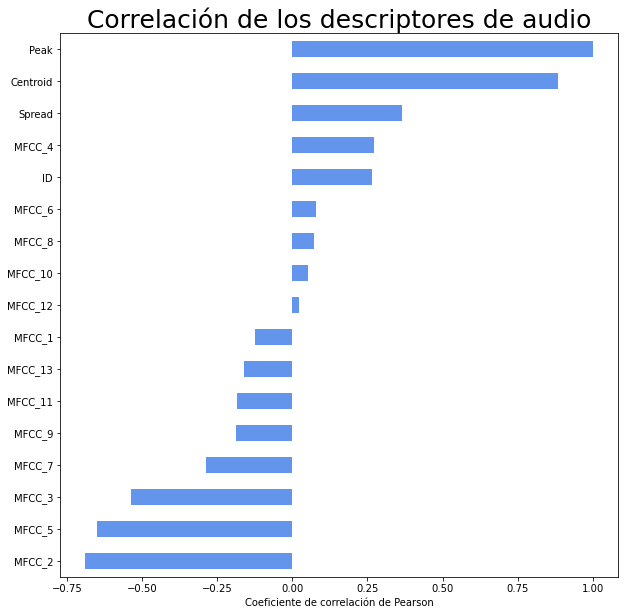

In [27]:
datos.corrwith(datos.Peak).sort_values().plot.barh(figsize=(10,10), color='cornflowerblue')
plt.xlabel('Coeficiente de correlación de Pearson')
plt.title('Correlación de los descriptores de audio', fontsize = 25);

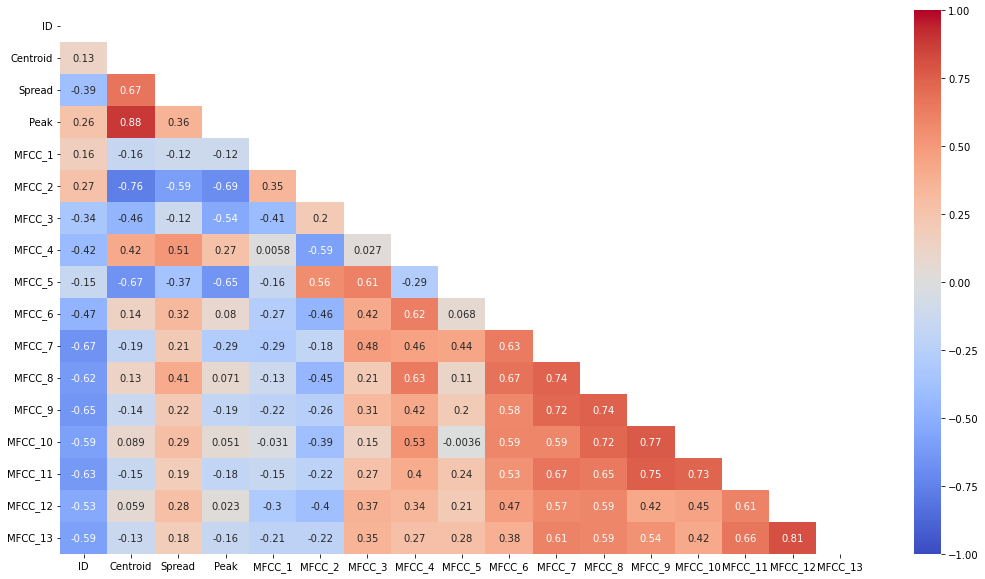

In [28]:
plt.figure(figsize=(18,10))
corr_df = datos.corr()
mask = np.triu(np.ones_like(corr_df))
sns.heatmap(datos.corr(),cmap='coolwarm',annot=True, annot_kws={'fontsize':10}, mask=mask, vmin=-1, vmax=1);

### SEE SOME DATA

In [29]:
plt.style.use("seaborn-poster")

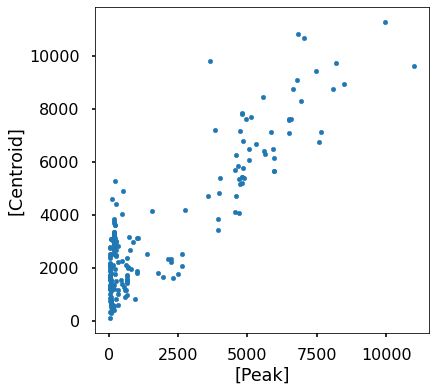

In [30]:
datos[['Peak', 'Centroid']].plot.scatter(x=['Peak'], y=['Centroid'], alpha=1, figsize=(6,6));

### DEFINE X NAMES FOR TRAINING

In [31]:
x_names = ['Centroid', 'Spread', 'Peak', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']
#x_names = ['Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Kurtosis', 'Entropy', 'Roll Off', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
#          'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']
#x_names = ['Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6']

### SPLIT TRAIN AND TEST DATA

In [32]:
x_train, x_test, y_train, y_test = train_test_split(datos[x_names], datos.ID, test_size=0.2, random_state=69)

## TRAIN WITH DECISIONS TREE

In [33]:
model_tree = DecisionTreeClassifier(max_depth=7)
model_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=7)

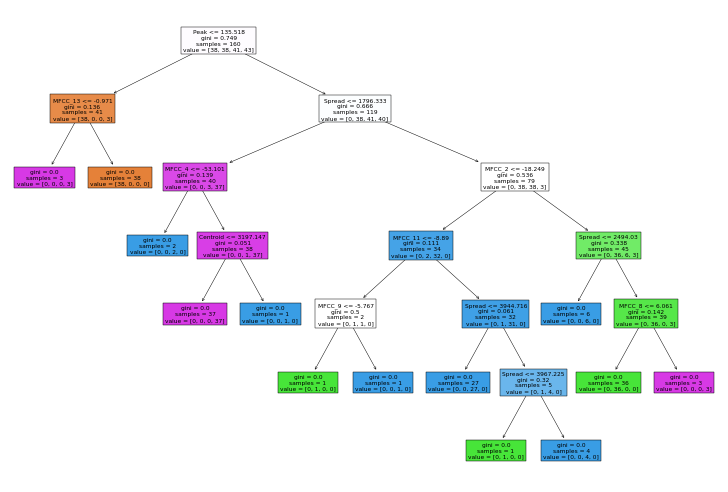

In [34]:
plt.figure()
plot_tree(model_tree, filled=True, feature_names= x_names)
plt.show()

### MAKE AND TEST PREDICTIONS

In [35]:
y_results_tree = model_tree.predict(x_test)
y_results_tree

array([2, 2, 4, 1, 4, 3, 3, 1, 3, 3, 1, 2, 4, 4, 1, 1, 1, 1, 2, 2, 4, 4,
       4, 2, 4, 2, 3, 3, 3, 1, 4, 1, 3, 2, 1, 2, 1, 3, 1, 2])

In [36]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0
guitarAcertados, numGuitar = 0, 0

for num in range(len(y_results_tree)):
    if x_test.index[num] <= 49:
        if y_results_tree[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_tree[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99 and x_test.index[num] <= 149:
        if y_results_tree[num] == 3:
            hihatAcertados += 1
        numHihat += 1
        
    elif x_test.index[num] > 149:
        if y_results_tree[num] == 4:
            guitarAcertados += 1
        numGuitar += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihats", hihatAcertados, "predijo como hihat")
print("De", numGuitar, "Guitars", guitarAcertados, "predijo como guitar")

De 12 kicks 12 predijo como kick
De 12 Snares 8 predijo como snare
De 9 Hihats 8 predijo como hihat
De 7 Guitars 6 predijo como guitar


In [109]:
print(classification_report(y_test,y_results_tree))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      0.83      0.91        12
           3       1.00      1.00      1.00         9
           4       0.78      1.00      0.88         7

    accuracy                           0.95        40
   macro avg       0.94      0.96      0.95        40
weighted avg       0.96      0.95      0.95        40



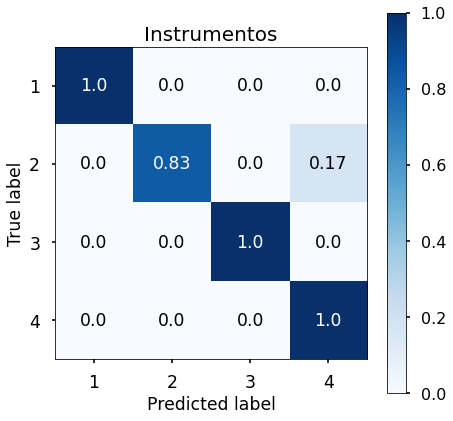

In [110]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_tree, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

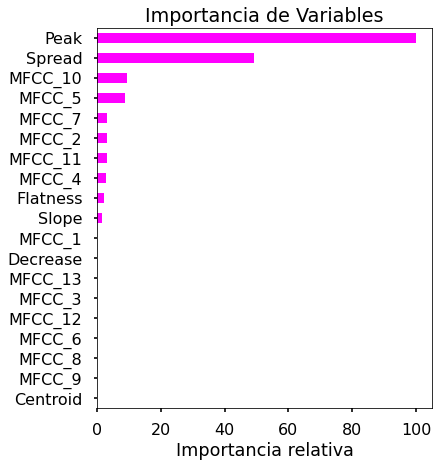

In [94]:
#DF de variables mas importantes
f_imp = pd.DataFrame(model_tree.feature_importances_,
                     index=x_names, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
#plot de importancia de variables
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7),
                                                              title='Importancia de Variables',color='magenta')
plt.xlabel('Importancia relativa');

TypeError: '(slice(None, None, None), 0)' is an invalid key

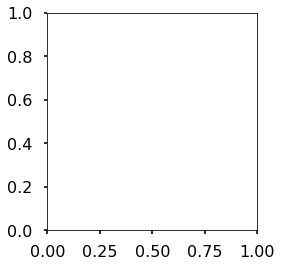

In [127]:
# Parameters
n_classes = 3 # número de clases a predecir
plot_colors = "ryb" #colores que usarán para pintar las fronteras y regiones
plot_step = 0.02 # resolución
max_depth_n = 7 # máxima profundidad permitida por el algoritmo

for pairidx, pair in enumerate([[1, 3], [2, 3],[1,2]]): # El par de columnas que se usará para entrenar cada modelo

    # Train
    clf = DecisionTreeClassifier(max_depth=max_depth_n).fit(x_train,y_train) # Se entrena el modelo con los parámetros especificados

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1) # subplot es para desplegar distintas gráficas de forma secuencial

    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1 # Aquí está generando el mallado sobre el que se construirá el gráfico
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) # Hace predicciones sobre el mallado para determinar las zonas de clasificación
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu) # Dibuja los contornos y asigna los colores correspondientes

    plt.xlabel(iris.feature_names[pair[0]]) # le pone las etiquetas correspondientes a los ejes
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15) # Agrega el gráfico de dispersión de los puntos con los que entrenó el modelo

plt.suptitle("Decision surface of a decision tree using paired features")
#plt.legend(loc='best', borderpad=0, handletextpad=0)
plt.axis("tight");

## TRAIN WITH LOGICTIC REGRESSION

### STANDARIZE DATA

In [31]:
# estandarizado
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

### TRAIN MODEL

In [32]:
# Entrenamiento del modelo
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

### MAKE AND TEST PREDICTIONS

In [33]:
y_results_logictic = model.predict(x_test)

In [34]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0

for num in range(len(x_test)):
    if x_test.index[num] <= 49:
        if y_results_logictic[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_logictic[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99:
        if y_results_logictic[num] == 3:
            hihatAcertados += 1
        numHihat += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihat", hihatAcertados, "predijo como hihat")

De 10 kicks 10 predijo como kick
De 8 Snares 6 predijo como snare
De 12 Hihat 11 predijo como hihat


### PREDICTIONS PROBABILITIES

In [35]:
y_hat_proba = model.predict_proba(x_test)
y_hat_proba[:10]

array([[8.83571115e-01, 3.14857281e-02, 8.49431568e-02],
       [3.25486838e-03, 4.48359661e-01, 5.48385471e-01],
       [8.65498487e-01, 1.30862335e-01, 3.63917846e-03],
       [3.11317693e-04, 4.43570804e-01, 5.56117878e-01],
       [8.00558046e-01, 1.97999867e-01, 1.44208779e-03],
       [7.29646507e-01, 2.68116533e-01, 2.23695990e-03],
       [4.33167393e-01, 5.48074289e-01, 1.87583178e-02],
       [1.79842631e-02, 5.94903403e-02, 9.22525397e-01],
       [8.74253789e-02, 1.30310583e-02, 8.99543563e-01],
       [7.67537848e-01, 2.30018981e-01, 2.44317109e-03]])

In [36]:
print(classification_report(y_test,y_results_logictic))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.86      0.75      0.80         8
           3       0.85      0.92      0.88        12

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



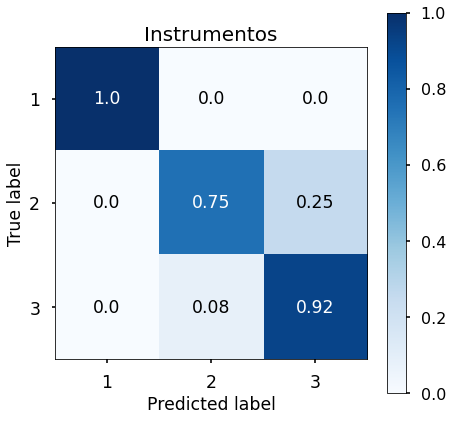

In [37]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_logictic, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [90]:
#print('Área bajo la curva ROC:',"% 1.3f" % roc_auc_score(y_test, y_hat, multi_class='ovr'))